In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import seaborn as sns
import numpy as np
from scipy import ndimage


sys.path.append('../../shared')
from file_analyzer import FileAnalyzer


# Analyze your file
analyzer = FileAnalyzer('../../../data/independent_expenditure_2024.csv')
analyzer.print_summary()

df = analyzer.get_dataframe()

# 2 Steps to cleaning data - first remove duplicates and then remove problematic spenders
# Remove duplicates keeping the latest file (amended reports)
df_clean = df.sort_values(['spe_id', 'exp_date', 'cand_id', 'file_num'])
df_clean = df_clean.drop_duplicates(subset=['spe_id', 'exp_date', 'cand_id', 'exp_amo'], keep='last')
df = df_clean

# Remove problematic spenders
spenders_to_remove = [
    'THE COMMITTEE OF 300',
    'THE COURT OF DIVINE JUSTICE', 
    'Republican Emo Girl',
    'The Masonic Illuminati Eye',
    'Gus Associates'
]

rows_to_remove = df['spe_nam'].isin(spenders_to_remove)
df = df[~df['spe_nam'].isin(spenders_to_remove)].copy()

# https://www.fec.gov/campaign-finance-data/independent-expenditures-file-description/




FILE ANALYSIS SUMMARY
📁 File: independent_expenditure_2024.csv
📊 Type: CSV
💾 Size: 18.6 MB
📈 Shape: (73403, 23)
🔢 Columns: 23
📋 Rows: 73403


In [55]:
df.head()

,cand_id,cand_name,spe_id,spe_nam,ele_type,can_office_state,can_office_dis,can_office,cand_pty_aff,exp_amo,exp_date,agg_amo,sup_opp,pur,pay,file_num,amndt_ind,tran_id,image_num,receipt_dat,fec_election_yr,prev_file_num,dissem_dt
1997,H2CO08020,"Caraveo, Yadira",C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,G,CO,8.0,H,DEMOCRATIC PARTY,410000.0,10-OCT-24,410000.00,S,Media Buy and Production,Strother Nuckels Strategies,1827568,N,ECDBC8A4E37664467818,202410159686550268,15-OCT-24,2024,NaN,15-OCT-24
1998,H8IA02043,"Miller-Meeks, Mariannette",C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,G,IA,1.0,H,REPUBLICAN PARTY,425000.0,10-OCT-24,425000.00,S,Media Buy and Production,"Prime Media Partners, LLC",1836238,N,E1FA5CED6F0C144D6969,202410239710110665,23-OCT-24,2024,NaN,23-OCT-24
18682,H2NY04277,"Desposito, Anthony",C00000935,DCCC,G,NY,4.0,H,REPUBLICAN PARTY,15000.0,01-OCT-24,2862008.09,O,Digital Media - Production Estimate,"Charles Rocha dba Solidarity Strategies, LLC",1822077,A1,SE-1085596,202410099684848881,09-OCT-24,2024,1819815.0,01-OCT-24
18872,H2WA03100,"Kent, Joseph",C00000935,DCCC,G,WA,3.0,H,REPUBLICAN PARTY,10000.0,01-OCT-24,2682891.00,O,Digital Media - Production Estimate,Wavelength Strategy LLC,1822077,A1,SE-1085598,202410099684848894,09-OCT-24,2024,1819815.0,01-OCT-24
18873,H2WA03100,"Kent, Joseph",C00000935,DCCC,G,WA,3.0,H,REPUBLICAN PARTY,15670.0,01-OCT-24,2682891.00,O,Media Production - Estimate,ZTribeca LLC,1822077,A1,SE-1085599,202410099684848894,09-OCT-24,2024,1819815.0,01-OCT-24


In [56]:

# Date parsing for plotting
df.loc[:, 'exp_date_parsed'] = pd.to_datetime(df['exp_date'], format='%d-%b-%y', errors='coerce')
df.loc[:, 'exp_month'] = df['exp_date_parsed'].dt.to_period('M')


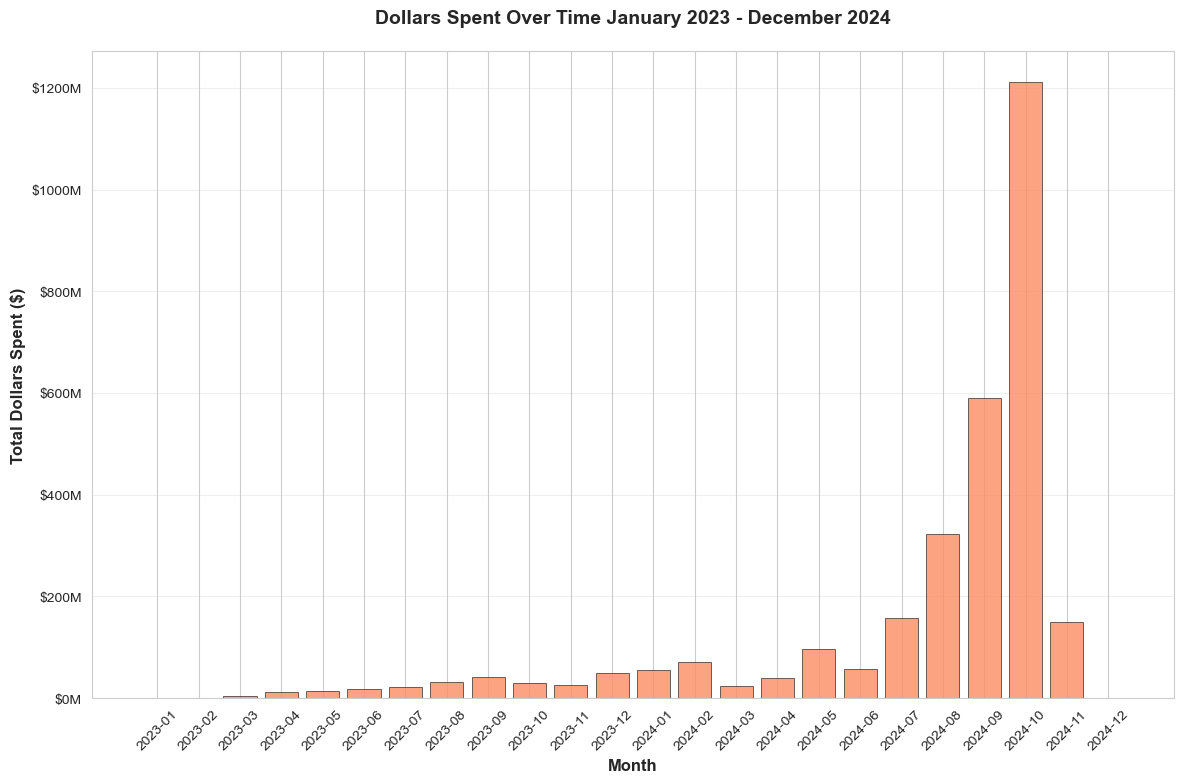

In [57]:
# Plot dollars spent over time (similar to expenditures plot but using sum of amounts)
plt.figure(figsize=(12, 8))
monthly_amounts = df.groupby('exp_month')['exp_amo'].sum().sort_index()

colors = sns.color_palette('Set2', len(monthly_amounts))
plt.bar(range(len(monthly_amounts)), monthly_amounts.values, 
        color=colors[1], alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Month', fontsize=12, fontweight='bold')
plt.ylabel('Total Dollars Spent ($)', fontsize=12, fontweight='bold')
plt.title('Dollars Spent Over Time January 2023 - December 2024', 
            fontsize=14, fontweight='bold', pad=20)
plt.xticks(range(len(monthly_amounts)), monthly_amounts.index, rotation=45)

# Format y-axis to show amounts in millions
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

plt.grid(axis='y', alpha=0.3)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.savefig('images/dollars_spent_over_time.png', dpi=300, bbox_inches='tight')
plt.show()


In [58]:
# Get total dollar amount spent across all time periods
total_spent = df['exp_amo'].sum()
print(f"Total amount spent across all time periods: ${total_spent:,.2f}")


Total amount spent across all time periods: $4,415,014,497.82


Top 20 spenders by total dollar amount:
spe_nam
FF PAC                                                                                    4.884767e+08
MAKE AMERICA GREAT AGAIN INC.                                                             3.811664e+08
WinSenate                                                                                 2.971746e+08
Senate Leadership Fund                                                                    2.110850e+08
Congressional Leadership Fund                                                             2.015903e+08
HMP                                                                                       1.725976e+08
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action    1.398614e+08
Food & Water Action                                                                       1.142088e+08
PRESERVE AMERICA PAC                                                                      1.123219e+08
America PAC              

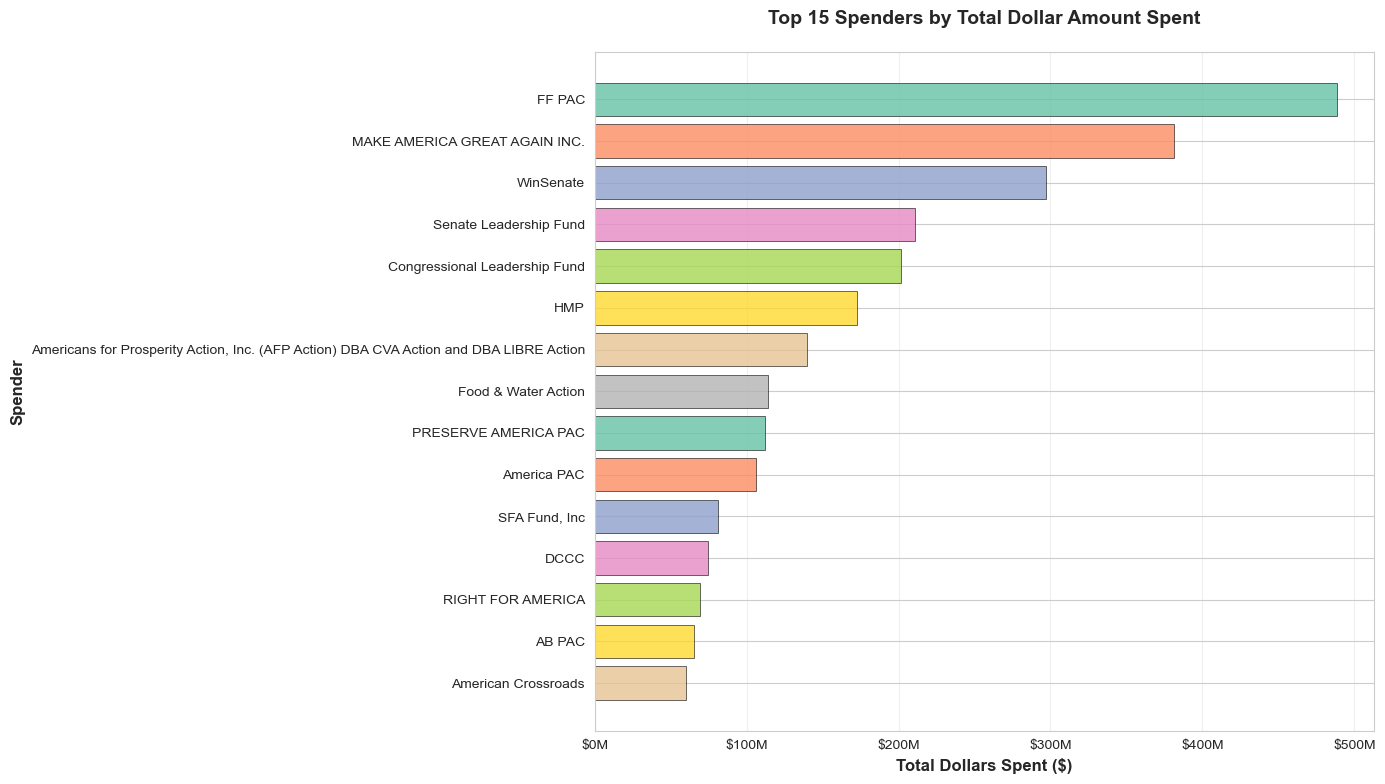


Total amount spent by top 15 spenders: $2,576,088,554.88
Percentage of total spending by top 15: 58.3%


In [59]:
# Calculate total dollar amounts spent by each spender
spender_amounts = df.groupby('spe_nam')['exp_amo'].sum().sort_values(ascending=False)

print(f"Top 20 spenders by total dollar amount:")
print(spender_amounts.head(20))
plt.figure(figsize=(14, 8))

top_spenders = spender_amounts.head(15)

colors = sns.color_palette('Set2', len(top_spenders))

bars = plt.barh(range(len(top_spenders)), top_spenders.values, 
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Total Dollars Spent ($)', fontsize=12, fontweight='bold')
plt.ylabel('Spender', fontsize=12, fontweight='bold')
plt.title('Top 15 Spenders by Total Dollar Amount Spent', 
          fontsize=14, fontweight='bold', pad=20)

plt.yticks(range(len(top_spenders)), top_spenders.index)

plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.0f}M'))

plt.grid(axis='x', alpha=0.3)
plt.gca().set_axisbelow(True)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('images/top_spenders_by_amount.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nTotal amount spent by top 15 spenders: ${top_spenders.sum():,.2f}")
print(f"Percentage of total spending by top 15: {(top_spenders.sum() / df['exp_amo'].sum()) * 100:.1f}%")


In [60]:
pd.set_option('display.max_columns', None)
# df.head()
df['cand_pty_aff'].value_counts()
# df[df['cand_name'].str.contains('Nate') & (df['exp_amo'] >= 123) & (df['exp_amo'] <= 20000)]
# df[df['exp_amo'] >= 8000000]

cand_pty_aff
DEMOCRATIC PARTY           23818
REPUBLICAN PARTY           21792
INDEPENDENT                  572
DEMOCRATIC-FARMER-LABOR      163
LIBERTARIAN PARTY             54
OTHER                         28
GREEN PARTY                   22
UNKNOWN                       16
UNAFFILIATED                   4
Name: count, dtype: int64

In [61]:
candidate_counts = df['cand_name'].value_counts()

print(f"Total number of distinct candidates: {len(candidate_counts)}")
print(f"\nTop 20 candidates by number of expenditures:")
print(candidate_counts.head(20))


Total number of distinct candidates: 1293

Top 20 candidates by number of expenditures:
cand_name
Harris, Kamala        5205
Trump, Donald         3225
HARRIS, KAMALA        2925
TRUMP, DONALD         1710
TRUMP, DONALD J.      1050
GALLEGO, RUBEN         913
SUAREZ, FRANCIS X.     821
HALEY, NIKKI           559
SHEEHY, TIM            541
BROWNLEY, JULIA        461
BILIRAKIS, GUS         459
ROSEN, JACKY           443
MORENO, BERNIE         441
BALDWIN, TAMMY         435
Baldwin, Tammy         419
SHAH, AMISH            376
ENGEL, KIRSTEN         370
BROWN, SAM             370
Biden, Joseph          339
RUTHERFORD, JOHN       333
Name: count, dtype: int64


In [62]:
print("Summary statistics:")
print(f"Total expenditures: {len(df)}")
print(f"Unique candidates: {df['cand_name'].nunique()}")
print(f"Average expenditures per candidate: {len(df) / df['cand_name'].nunique():.2f}")

print(f"\nCandidates with most expenditures:")
print(candidate_counts.head(10))

print(f"\nCandidates with least expenditures (appearing only once):")
single_occurrence = candidate_counts[candidate_counts == 1]
print(f"Number of candidates appearing only once: {len(single_occurrence)}")
print(single_occurrence.head(10))


Summary statistics:
Total expenditures: 53991
Unique candidates: 1293
Average expenditures per candidate: 41.76

Candidates with most expenditures:
cand_name
Harris, Kamala        5205
Trump, Donald         3225
HARRIS, KAMALA        2925
TRUMP, DONALD         1710
TRUMP, DONALD J.      1050
GALLEGO, RUBEN         913
SUAREZ, FRANCIS X.     821
HALEY, NIKKI           559
SHEEHY, TIM            541
BROWNLEY, JULIA        461
Name: count, dtype: int64

Candidates with least expenditures (appearing only once):
Number of candidates appearing only once: 228
cand_name
BAECHLER, MARY                 1
COUHGLIN, KEVIN                1
SIDDIQI, IMRAAN                1
BARR, CALLIE                   1
0'Callahan, Conor              1
Espaillat, Adriano             1
Nick, Lalota                   1
MCFARLANE, WALTER JAMES III    1
BILLIPS, NATHAN                1
Terry, Randell                 1
Name: count, dtype: int64


In [63]:
spender_counts = df['spe_nam'].value_counts()

print(f"Total number of distinct spenders: {len(spender_counts)}")
print(f"\nTop 20 spenders by number of expenditures:")
print(spender_counts.head(20))

Total number of distinct spenders: 1069

Top 20 spenders by number of expenditures:
spe_nam
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action    2280
Congressional Leadership Fund                                                             1609
Worker Power                                                                              1485
SENATE CONSERVATIVES FUND                                                                 1367
RED SENATE                                                                                1279
SUPPORT AMERICA'S POLICE PAC                                                              1121
HMP                                                                                       1012
Republican Accountability PAC                                                              972
SOS AMERICA PAC                                                                            825
Working America                                      

In [64]:
# Examine the four key columns
columns_to_examine = ['spe_nam', 'cand_pty_aff', 'pur', 'exp_amo']

print("Column Information:")
print("=" * 50)
for col in columns_to_examine:
    print(f"\n{col}:")
    print(f"  Data type: {df[col].dtype}")
    print(f"  Non-null count: {df[col].notna().sum()}")
    print(f"  Null count: {df[col].isna().sum()}")
    print(f"  Unique values: {df[col].nunique()}")
    
    if col == 'exp_amo':
        print(f"  Min value: ${df[col].min():,.2f}")
        print(f"  Max value: ${df[col].max():,.2f}")
        print(f"  Mean value: ${df[col].mean():,.2f}")
        print(f"  Median value: ${df[col].median():,.2f}")
    else:
        print(f"  Sample values: {df[col].dropna().head(5).tolist()}")


Column Information:

spe_nam:
  Data type: object
  Non-null count: 53988
  Null count: 3
  Unique values: 1069
  Sample values: ['AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE', 'AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION COMMITTEE', 'DCCC', 'DCCC', 'DCCC']

cand_pty_aff:
  Data type: object
  Non-null count: 46469
  Null count: 7522
  Unique values: 9
  Sample values: ['DEMOCRATIC PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY', 'REPUBLICAN PARTY']

pur:
  Data type: object
  Non-null count: 53982
  Null count: 9
  Unique values: 5445
  Sample values: ['Media Buy and Production', 'Media Buy and Production', 'Digital Media -  Production Estimate', 'Digital Media -  Production Estimate', 'Media Production - Estimate']

exp_amo:
  Data type: float64
  Non-null count: 53991
  Null count: 0
  Unique values: 30214
  Min value: $-580,000.00
  Max value: $114,056,874.00
  Mean value: $81,773.16
  Median value: $2,760.00


In [65]:
print("TOP 15 SPENDERS BY DOLLAR AMOUNT:")
print("=" * 50)
top_spenders_by_amount = df.groupby('spe_nam')['exp_amo'].sum().sort_values(ascending=False).head(15)
for spender, total_amount in top_spenders_by_amount.items():
    print(f"{spender}: ${total_amount:,.2f}")

print(f"\nTotal unique spenders: {df['spe_nam'].nunique():,}")


TOP 15 SPENDERS BY DOLLAR AMOUNT:
FF PAC: $488,476,651.35
MAKE AMERICA GREAT AGAIN INC.: $381,166,419.49
WinSenate: $297,174,584.54
Senate Leadership Fund: $211,084,995.66
Congressional Leadership Fund: $201,590,329.26
HMP: $172,597,570.83
Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE Action: $139,861,364.79
Food & Water Action: $114,208,840.16
PRESERVE AMERICA PAC: $112,321,879.52
America PAC: $106,300,393.66
SFA Fund, Inc: $81,182,993.18
DCCC: $74,778,403.64
RIGHT FOR AMERICA: $69,583,233.16
AB PAC: $65,547,002.18
American Crossroads: $60,213,893.46

Total unique spenders: 1,069


In [66]:
print("CANDIDATE PARTY AFFILIATIONS:")
print("=" * 50)
party_counts = df['cand_pty_aff'].value_counts()
for party, count in party_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{party}: {count:,} ({percentage:.1f}%)")

print(f"\nTotal unique parties: {df['cand_pty_aff'].nunique()}")
print(f"Missing party data: {df['cand_pty_aff'].isna().sum():,} ({df['cand_pty_aff'].isna().sum()/len(df)*100:.1f}%)")


CANDIDATE PARTY AFFILIATIONS:
DEMOCRATIC PARTY: 23,818 (44.1%)
REPUBLICAN PARTY: 21,792 (40.4%)
INDEPENDENT: 572 (1.1%)
DEMOCRATIC-FARMER-LABOR: 163 (0.3%)
LIBERTARIAN PARTY: 54 (0.1%)
OTHER: 28 (0.1%)
GREEN PARTY: 22 (0.0%)
UNKNOWN: 16 (0.0%)
UNAFFILIATED: 4 (0.0%)

Total unique parties: 9
Missing party data: 7,522 (13.9%)


EXPENDITURE PURPOSES:
Payroll: 1,455 (2.7%)
DIGITAL ADS: 1,249 (2.3%)
PHONEBANK PAYROLL SERVICES(ESTIMATE): 1,128 (2.1%)
PHONEBANK IT/TECH SUPPORT(ESTIMATE): 1,117 (2.1%)
CAGING AND DATABASE SERVICES(ESTIMATE): 1,106 (2.0%)
LEADS / PHONE LISTS(ESTIMATE): 1,065 (2.0%)
MEDIA PLACEMENT: 975 (1.8%)
MEDIA PRODUCTION: 889 (1.6%)
Digital Advertising: 758 (1.4%)
MEDIA: 610 (1.1%)
MAILER POSTAGE: 609 (1.1%)
DIRECT MAIL: 557 (1.0%)
TEXT MESSAGES: 471 (0.9%)
Direct Mail: 456 (0.8%)
MMS Messaging (Estimate): 406 (0.8%)
Canvassing: 396 (0.7%)
PRINTING / POSTAGE: 395 (0.7%)
Leads / Phone Lists(Estimate): 394 (0.7%)
PHONEBANK IT/TECH SUPPORT(Estimate): 391 (0.7%)
Caging and Database Services(Estimate): 391 (0.7%)
Phonebank Payroll Services(Estimate): 391 (0.7%)
CANVASSING: 382 (0.7%)
Media Buy: 358 (0.7%)
Digital Advertising - Estimate: 334 (0.6%)
DIGITAL PLACEMENT: 328 (0.6%)
Media Production - Estimate: 325 (0.6%)
MAILER PRODUCTION: 325 (0.6%)
Digital advertising: 310 (0.6%)
MMS Messaging: 283 (0.5

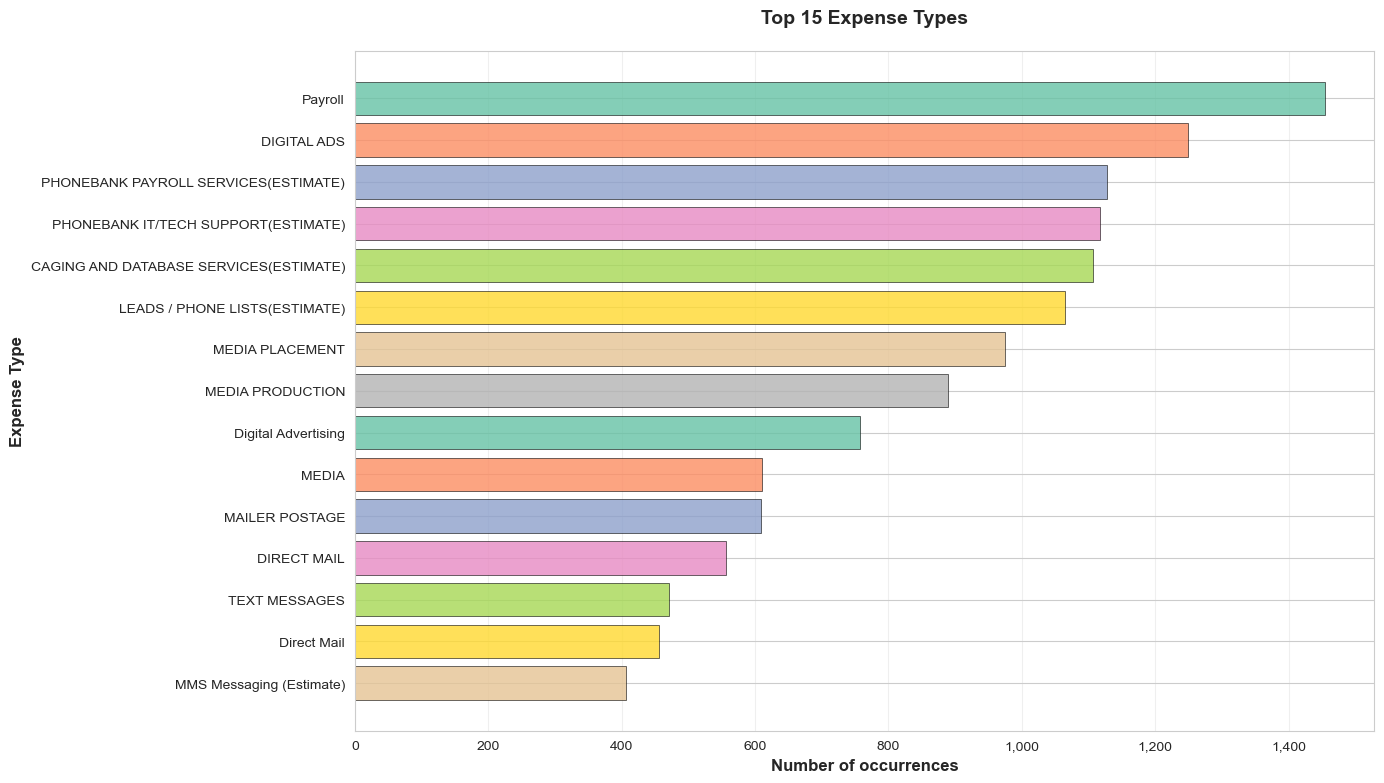

Percentage of total expenditures by top 15 types: 23.8%


In [77]:
print("EXPENDITURE PURPOSES:")
print("=" * 50)
purpose_counts = df['pur'].value_counts()
for purpose, count in purpose_counts.items():
    percentage = (count / len(df)) * 100
    print(f"{purpose}: {count:,} ({percentage:.1f}%)")

# Get top 15 expense types by count
top_15_purposes = purpose_counts.head(15)

plt.figure(figsize=(14, 8))

colors = sns.color_palette('Set2', len(top_15_purposes))

bars = plt.barh(range(len(top_15_purposes)), top_15_purposes.values, 
                color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Number of occurrences', fontsize=12, fontweight='bold')
plt.ylabel('Expense Type', fontsize=12, fontweight='bold')
plt.title('Top 15 Expense Types', 
          fontsize=14, fontweight='bold', pad=20)

plt.yticks(range(len(top_15_purposes)), top_15_purposes.index)

# Format x-axis as counts (not currency)
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{int(x):,}'))

plt.grid(axis='x', alpha=0.3)
plt.gca().set_axisbelow(True)

plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('images/top_expense_types_by_count.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Percentage of total expenditures by top 15 types: {(top_15_purposes.sum() / purpose_counts.sum()) * 100:.1f}%")



In [68]:
print("EXPENDITURE AMOUNTS ANALYSIS:")
print("=" * 50)

print(f"Total expenditures: {len(df):,}")
print(f"Total amount spent: ${df['exp_amo'].sum():,.2f}")
print(f"Average expenditure: ${df['exp_amo'].mean():,.2f}")
print(f"Median expenditure: ${df['exp_amo'].median():,.2f}")
print(f"Largest single expenditure: ${df['exp_amo'].max():,.2f}")
print(f"Smallest single expenditure: ${df['exp_amo'].min():,.2f}")

# Distribution by amount ranges
print(f"\nEXPENDITURE AMOUNT DISTRIBUTION:")
ranges = [
    (0, 100, "Under $100"),
    (100, 1000, "$100 - $1,000"),
    (1000, 10000, "$1,000 - $10,000"),
    (10000, 100000, "$10,000 - $100,000"),
    (100000, float('inf'), "Over $100,000")
]

for min_amt, max_amt, label in ranges:
    if max_amt == float('inf'):
        count = len(df[df['exp_amo'] >= min_amt])
    else:
        count = len(df[(df['exp_amo'] >= min_amt) & (df['exp_amo'] < max_amt)])
    percentage = (count / len(df)) * 100
    print(f"{label}: {count:,} ({percentage:.1f}%)")


EXPENDITURE AMOUNTS ANALYSIS:
Total expenditures: 53,991
Total amount spent: $4,415,014,497.82
Average expenditure: $81,773.16
Median expenditure: $2,760.00
Largest single expenditure: $114,056,874.00
Smallest single expenditure: $-580,000.00

EXPENDITURE AMOUNT DISTRIBUTION:
Under $100: 8,212 (15.2%)
$100 - $1,000: 13,211 (24.5%)
$1,000 - $10,000: 12,937 (24.0%)
$10,000 - $100,000: 13,697 (25.4%)
Over $100,000: 5,915 (11.0%)


In [69]:
print("LARGEST EXPENDITURES:")
print("=" * 50)
top_expenditures = df.nlargest(10, 'exp_amo')[['spe_nam', 'cand_name', 'cand_pty_aff', 'pur', 'exp_amo']]
for idx, row in top_expenditures.iterrows():
    print(f"${row['exp_amo']:,.2f} - {row['spe_nam']} → {row['cand_name']} ({row['cand_pty_aff']}) - {row['pur']}")

print(f"\nLARGEST SPENDERS BY TOTAL AMOUNT:")
print("=" * 50)
spender_totals = df.groupby('spe_nam')['exp_amo'].sum().sort_values(ascending=False).head(10)
for spender, total in spender_totals.items():
    print(f"{spender}: ${total:,.2f}")


LARGEST EXPENDITURES:
$114,056,874.00 - Food & Water Action → Harris, Kamala (DEMOCRATIC PARTY) - Voter outreach
$30,033,271.32 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$24,083,279.00 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,798,392.46 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,147,260.79 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,102,885.83 - MAKE AMERICA GREAT AGAIN INC. → HARRIS, KAMALA (DEMOCRATIC PARTY) - PLACED MEDIA: TV
$21,016,914.21 - FF PAC → Harris, Kamala (DEMOCRATIC PARTY) - Media Buy and Ad Servicing (Estimate)
$18,986,237.00 - FF PAC → Harris, Kamala (DEMOCRATIC PARTY) - Media Buy and Ad Servicing (Estimate)
$17,300,000.00 - RBG PAC → TRUMP, DONALD J. (REPUBLICAN PARTY) - DIGITAL MEDIA
$16,717,500.00 - Americans for Prosperity Action, Inc. (AFP Action) DBA CVA Action and DBA LIBRE A

In [70]:
spending_purposes = df['pur'].value_counts()

print(f"Total number of distinct spending purposes: {len(spending_purposes)}")
print(f"\nTop 20 spending purposes by number of expenditures:")
print(spending_purposes.head(20))



Total number of distinct spending purposes: 5445

Top 20 spending purposes by number of expenditures:
pur
Payroll                                   1455
DIGITAL ADS                               1249
PHONEBANK PAYROLL SERVICES(ESTIMATE)      1128
PHONEBANK IT/TECH SUPPORT(ESTIMATE)       1117
CAGING AND DATABASE SERVICES(ESTIMATE)    1106
LEADS / PHONE LISTS(ESTIMATE)             1065
MEDIA PLACEMENT                            975
MEDIA PRODUCTION                           889
Digital Advertising                        758
MEDIA                                      610
MAILER POSTAGE                             609
DIRECT MAIL                                557
TEXT MESSAGES                              471
Direct Mail                                456
MMS Messaging (Estimate)                   406
Canvassing                                 396
PRINTING / POSTAGE                         395
Leads / Phone Lists(Estimate)              394
PHONEBANK IT/TECH SUPPORT(Estimate)        391
C

/var/folders/02/c1hvrmj11kx0z457p84l6pbc0000gn/T/ipykernel_27996/27582385.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, y='Category', x='Percentage',


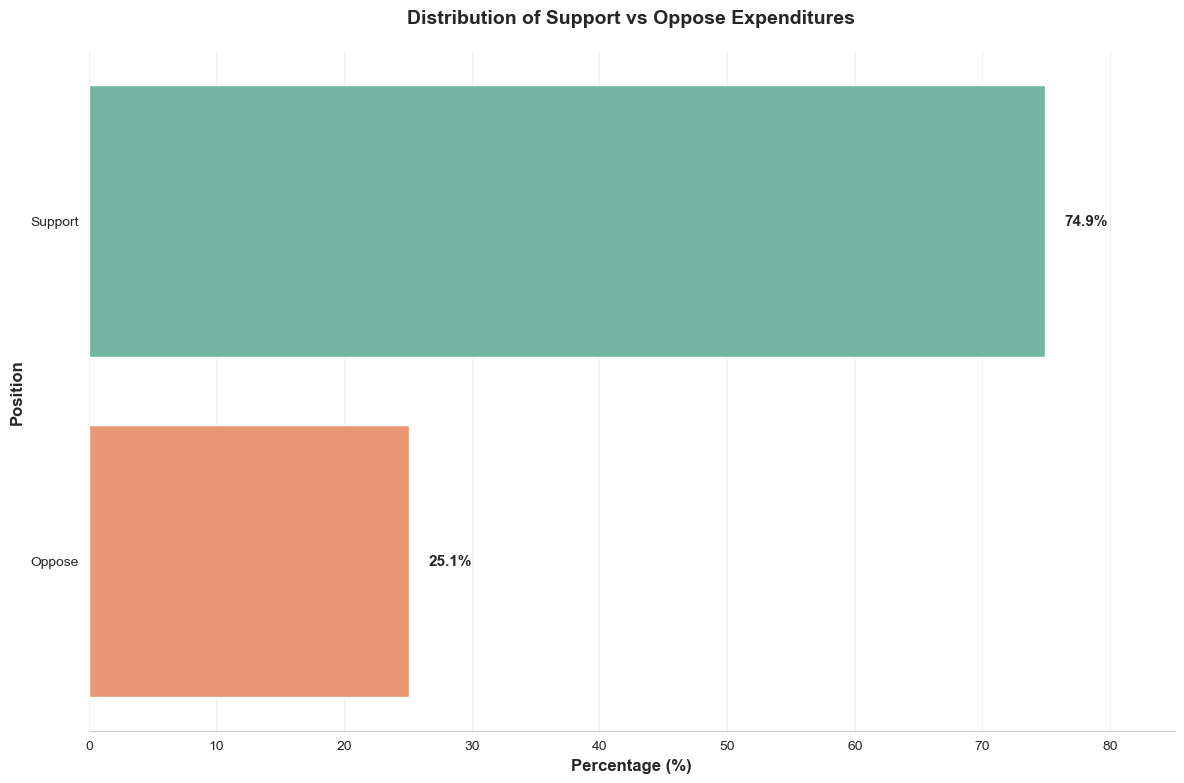

In [71]:
sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

categories = ['Support', 'Oppose'] 
values = [74.9, 25.1]

plot_df = pd.DataFrame({
    'Category': categories,
    'Percentage': values
})

plt.figure(figsize=(12, 8))

ax = sns.barplot(data=plot_df, y='Category', x='Percentage', 
                palette='Set2', orient='h')

plt.title('Distribution of Support vs Oppose Expenditures', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Percentage (%)', fontsize=12, fontweight='bold')
plt.ylabel('Position', fontsize=12, fontweight='bold')

for i, (category, value) in enumerate(zip(categories, values)):
    ax.text(value + 1.5, i, f'{value}%', 
            va='center', ha='left', fontweight='bold', fontsize=11)

ax.grid(axis='x', alpha=0.3)
ax.set_axisbelow(True)
sns.despine(left=True, bottom=False)

plt.xlim(0, 85)

# Adjust layout and save
plt.tight_layout()
plt.savefig('images/support_oppose_seaborn.png', dpi=300, bbox_inches='tight')
plt.show()


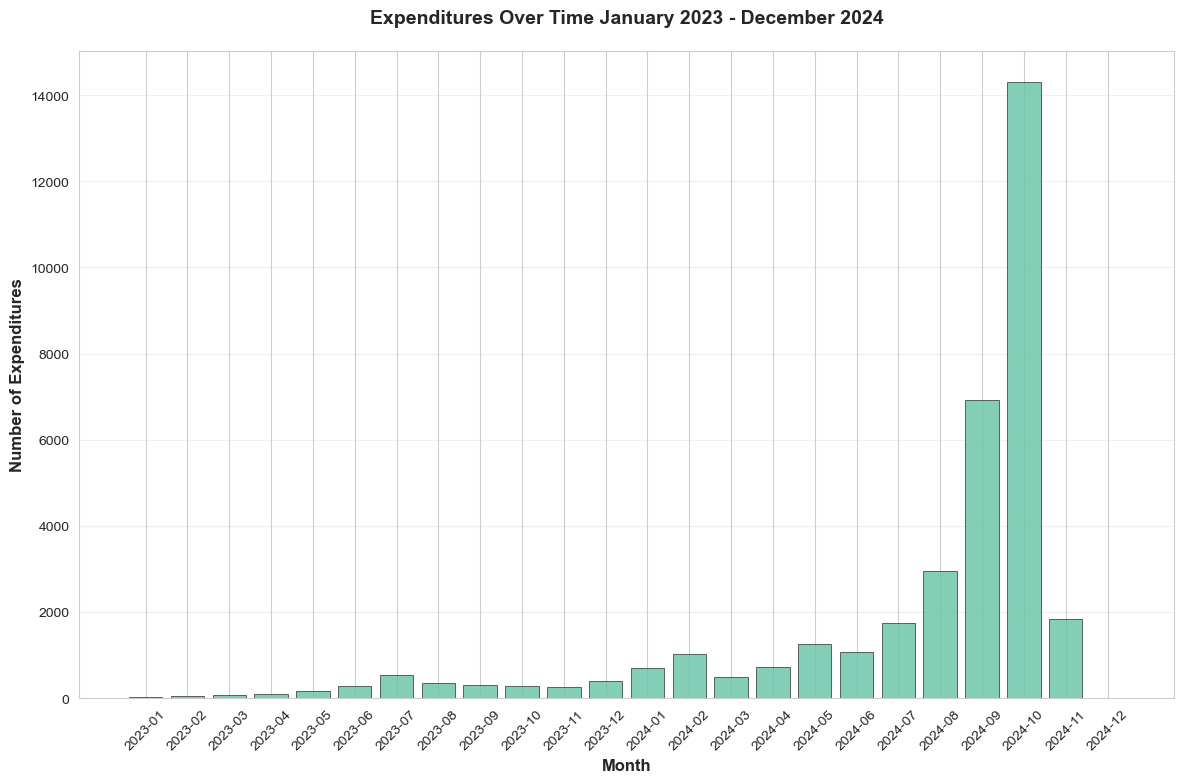

In [72]:
if 'exp_month' in df.columns:
    plt.figure(figsize=(12, 8))
    monthly_counts = df['exp_month'].value_counts().sort_index()
    
    colors = sns.color_palette('Set2', len(monthly_counts))
    plt.bar(range(len(monthly_counts)), monthly_counts.values, 
            color=colors[0], alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Month', fontsize=12, fontweight='bold')
    plt.ylabel('Number of Expenditures', fontsize=12, fontweight='bold')
    plt.title('Expenditures Over Time January 2023 - December 2024', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xticks(range(len(monthly_counts)), monthly_counts.index, rotation=45)
    
    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig('images/expenditures_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()

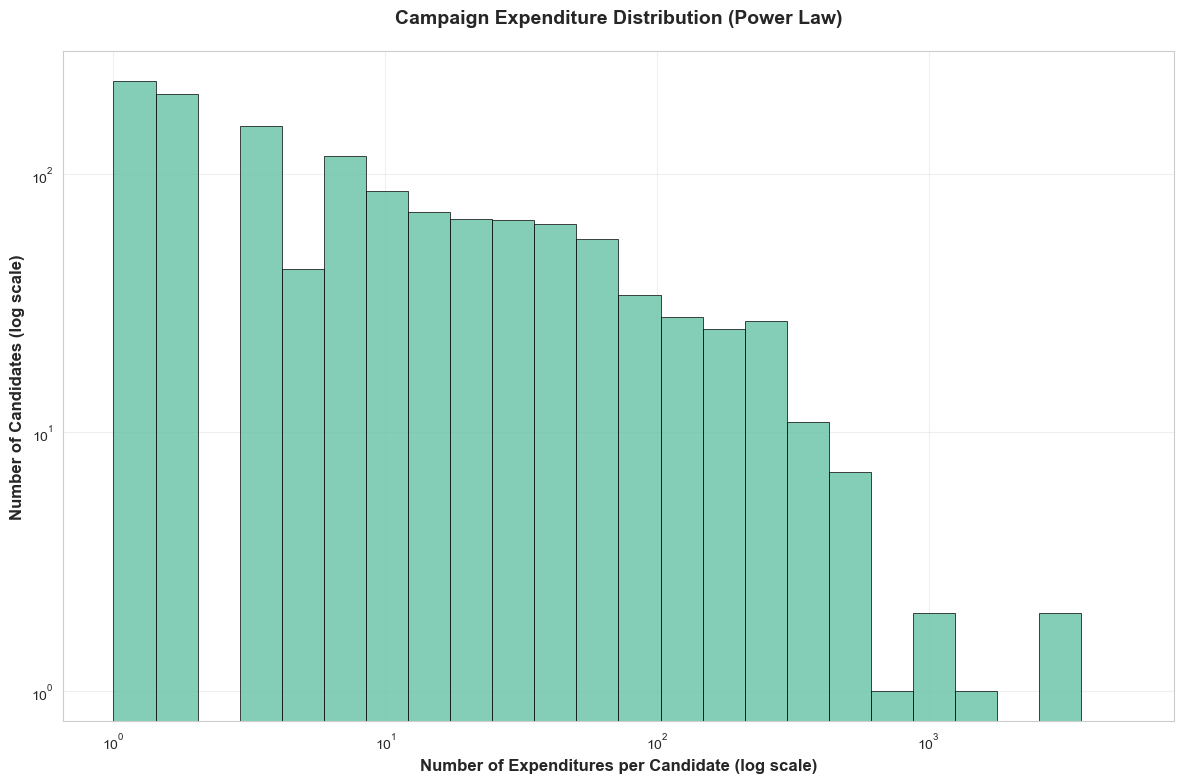

In [73]:
expenditures_per_candidate = df['cand_name'].value_counts()

plt.figure(figsize=(12, 8))
log_bins = np.logspace(0, np.log10(expenditures_per_candidate.max()), 25)

colors = sns.color_palette('Set2', 1)
sns.histplot(expenditures_per_candidate, bins=log_bins, alpha=0.8, 
             color=colors[0], edgecolor='black', linewidth=0.5)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Expenditures per Candidate (log scale)', 
           fontsize=12, fontweight='bold')
plt.ylabel('Number of Candidates (log scale)', 
           fontsize=12, fontweight='bold')
plt.title('Campaign Expenditure Distribution (Power Law)', 
          fontsize=14, fontweight='bold', pad=20)

plt.grid(True, alpha=0.3)
plt.gca().set_axisbelow(True)

plt.tight_layout()
plt.savefig('images/expenditure_amounts_by_party_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

AI assistance: Claude (Anthropic); prompts: "I am trying to capture a power law distribution in plotting campaign expenditure data - looking at Candidates and the count of expenditures... What would be a nice way to plot this as it tails off quickly from here. There are 1,323 entries. I would like to use seaborn. I am thinking a displot and would like some guidance on setting up bins to properly capture this" and "Explain this graph to me"; used for: generating Python code for power law visualization with logarithmic binning and seaborn, and explaining the resulting graph interpretation; changes: adapted the provided code examples to my specific dataset and selected the log-log scale approach; verification: tested the code with my campaign expenditure data, confirmed the power law pattern matches the theoretical expectations, and validated the graph interpretation against the raw data statistics.

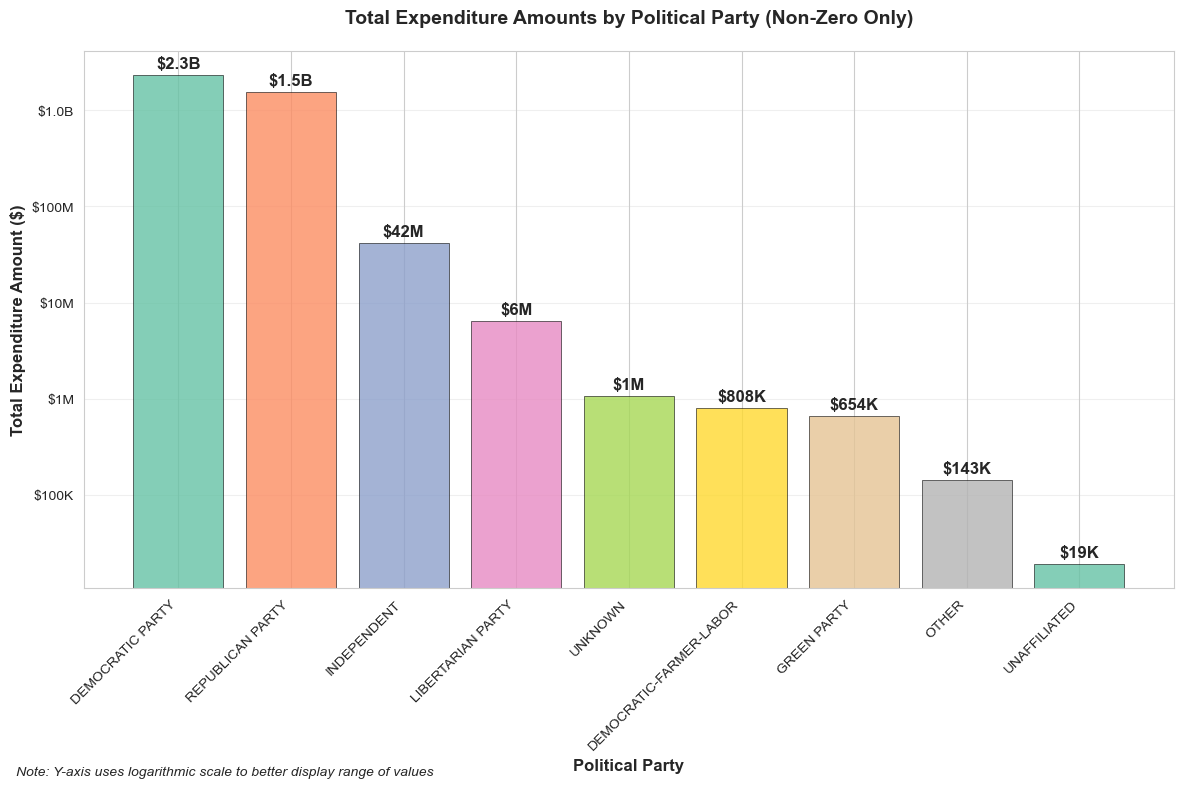

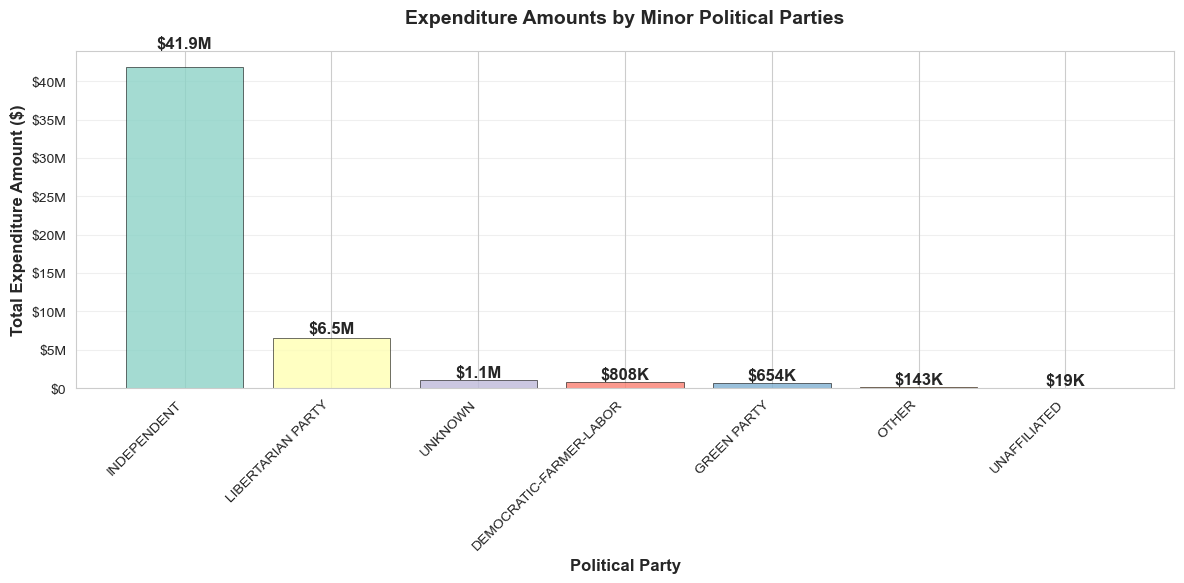

In [74]:
plt.figure(figsize=(12, 8))

party_expenditures = df.groupby('cand_pty_aff')['exp_amo'].sum().sort_values(ascending=False)

party_expenditures_filtered = party_expenditures[party_expenditures > 0]

colors = sns.color_palette('Set2', len(party_expenditures_filtered))

bars = plt.bar(range(len(party_expenditures_filtered)), party_expenditures_filtered.values, 
               color=colors, alpha=0.8, edgecolor='black', linewidth=0.5)

plt.xlabel('Political Party', fontsize=12, fontweight='bold')
plt.ylabel('Total Expenditure Amount ($)', fontsize=12, fontweight='bold')
plt.title('Total Expenditure Amounts by Political Party (Non-Zero Only)', 
          fontsize=14, fontweight='bold', pad=20)

plt.xticks(range(len(party_expenditures_filtered)), party_expenditures_filtered.index, 
           rotation=45, ha='right')

plt.yscale('log')

def format_currency(x, p):
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.0f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_currency))

plt.grid(axis='y', alpha=0.3)
plt.gca().set_axisbelow(True)

for i, (party, amount) in enumerate(party_expenditures_filtered.items()):
    if amount >= 1e9:
        label = f'${amount/1e9:.1f}B'
    elif amount >= 1e6:
        label = f'${amount/1e6:.0f}M'
    elif amount >= 1e3:
        label = f'${amount/1e3:.0f}K'
    else:
        label = f'${amount:.0f}'
    
    plt.text(i, amount * 1.1, label, ha='center', va='bottom', fontweight='bold')

plt.figtext(0.02, 0.02, 'Note: Y-axis uses logarithmic scale to better display range of values', 
            fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('images/expenditure_by_party_improved.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(12, 6))

minor_parties = party_expenditures_filtered.iloc[2:]

if len(minor_parties) > 0:
    colors_minor = sns.color_palette('Set3', len(minor_parties))
    
    bars = plt.bar(range(len(minor_parties)), minor_parties.values, 
                   color=colors_minor, alpha=0.8, edgecolor='black', linewidth=0.5)
    
    plt.xlabel('Political Party', fontsize=12, fontweight='bold')
    plt.ylabel('Total Expenditure Amount ($)', fontsize=12, fontweight='bold')
    plt.title('Expenditure Amounts by Minor Political Parties', 
              fontsize=14, fontweight='bold', pad=20)
    
    plt.xticks(range(len(minor_parties)), minor_parties.index, rotation=45, ha='right')
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_currency))
    
    plt.grid(axis='y', alpha=0.3)
    plt.gca().set_axisbelow(True)
    
    # Add value labels
    for i, (party, amount) in enumerate(minor_parties.items()):
        if amount >= 1e6:
            label = f'${amount/1e6:.1f}M'
        elif amount >= 1e3:
            label = f'${amount/1e3:.0f}K'
        else:
            label = f'${amount:.0f}'
        
        plt.text(i, amount * 1.05, label, ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('images/minor_party_expenditures.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("No minor parties with expenditures found for separate visualization.")

AI assistance: Claude (Anthropic Sonnet 4); prompts: "How can we improve this plot so that it better captures spending by party."; used for code optimization and data visualization improvements; changes: generated Python code with logarithmic scaling, filtered zero values, improved currency formatting, and created dual-chart approach; verification: reviewed code logic, formatting functions, and visualization principles for accuracy.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53991 entries, 1997 to 2868
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   cand_id           47406 non-null  object        
 1   cand_name         53991 non-null  object        
 2   spe_id            53991 non-null  object        
 3   spe_nam           53988 non-null  object        
 4   ele_type          53991 non-null  object        
 5   can_office_state  45100 non-null  object        
 6   can_office_dis    53972 non-null  float64       
 7   can_office        53978 non-null  object        
 8   cand_pty_aff      46469 non-null  object        
 9   exp_amo           53991 non-null  float64       
 10  exp_date          35873 non-null  object        
 11  agg_amo           53907 non-null  float64       
 12  sup_opp           53950 non-null  object        
 13  pur               53982 non-null  object        
 14  pay               53991 n